# Group Project Proposal - Predicting the Winner of a Tennis Match

## Introduction

Tennis is a popular racket sport throughout the world and has a large competitive scene. There are many competitions held throughout the world for tennis, to try to find the best tennis player in the world. Professional tennis players are ranked through the ATP ranking system, awarding points based on their tournament performances. For instance, a player would earn more points for making it deep into a tournament. In this project, we will attempt to answer the question: “Can we predict the winner of a match between two professional players?” The dataset we will be using to create our classification model are the results of games between 2017 and 2019 of the top 500 tennis players. In this dataset, there is information about the various tournaments in the time period, information about the players that played in the tournament, and information about their wins and losses in those tournaments. There is also data about the player’s ATP rank and how many points they gained from each tournament. 


## Preliminary Exploratory Data Analysis

In [158]:
options(repr.matrix.max.rows = 6)

library(tidyverse)
library(repr)
library(tidymodels)

In [187]:
tennis <- read_csv("tennis.csv", na = c("", "NA"))

## Cleaning and Wrangling
## Data is already tidy, with one observation per row being one match. However, this is not the most useful format for our question.
## Only get data from 2019
tennis <- tennis |>
    slice(1:2563)
tennis

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2778,2019-M-DC-2019-QLS-M-SWE-COL-01,Davis Cup QLS R1: SWE vs COL,Clay,4,D,20190201,1,105053,NA,⋯,33,20,7,9,1,5,251,190,116,485
2779,2019-M-DC-2019-QLS-M-SWE-COL-01,Davis Cup QLS R1: SWE vs COL,Clay,4,D,20190201,2,123755,NA,⋯,31,14,9,7,2,6,228,224,194,267
2780,2019-M-DC-2019-QLS-M-SWE-COL-01,Davis Cup QLS R1: SWE vs COL,Clay,4,D,20190201,4,105292,NA,⋯,29,17,8,9,4,9,337,72,116,485


In [205]:
##Get data for each player by tournament
players_data <- tennis |>
    group_by(winner_name, tourney_name) |>
    summarize(
        winning_match_count = sum(tennis$winner_name == winner_name),
        losing_match_count = sum(tennis$loser_name == winner_name),
        winner_rank = winner_rank,
        loser_rank = loser_rank,
        loser_name = loser_name,
        match_num = match_num, 
        match_count = winning_match_count + losing_match_count,
        winner_win_percent = winning_match_count / match_count
    )|>
    arrange(desc(winner_win_percent))

## Winner rank (of a match)
average_winner_ranks <- players_data |>
    group_by(winner_name) |>
    summarize(avg_rank = mean(winner_rank, na.rm = TRUE),
             winner_win_percent = mean(winner_win_percent, na.rm = TRUE)) |>
    arrange(avg_rank)

## Loser rank (of a match)
average_loser_ranks <- players_data |>
    group_by(loser_name) |>
    summarize(avg_rank = mean(loser_rank, na.rm = TRUE)) |>
    arrange(avg_rank)



loser_winrates <- c()

for (x in 1:nrow(players_data)) {
    row <- players_data[x, ]
    match <- "FALSE"
    
    for (y in 1:nrow(average_winner_ranks)) {
        row2 <- average_winner_ranks[y, ]
        if (row$loser_name == row2$winner_name) {
            loser_winrates <- rbind(loser_winrates, row2$winner_win_percent)
            match <- "TRUE"
            break
        }

    }

    if (match == "FALSE") {
        loser_winrates <- rbind(loser_winrates, 0)
    }
}

match_data <- cbind(players_data, loser_winrates)
names(match_data)[names(match_data) == "...11"] <- "loser_win_percentage"

match_split <- initial_split(players_data, prop = 0.75, strata = winner_name)
match_training <- training(match_split)
match_testing <- testing(match_split)

## match data with winner and loser winrates is acquired

#rank_when_win_match <- tennis |>
#    group_by(winner_name, tourney_name) |>
#    summarize(winner_rank = winner_rank) |>
#    drop_na(winner_rank)

#head(rank_when_win_match)

Warning message:
“There were 1304 warnings in `summarize()`.
The first warning was:
ℹ In argument: `winning_match_count = sum(tennis$winner_name == winner_name)`.
ℹ In group 1: `winner_name = "Adrian Mannarino"`, `tourney_name =
  "'s-Hertogenbosch"`.
Caused by warning in `tennis$winner_name == winner_name`:
! longer object length is not a multiple of shorter object length
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1303 remaining warnings.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'winner_name', 'tourney_name'. You can
override using the `.groups` argument.
New names:
• `` -> `...11`


winner_name,tourney_name,winning_match_count,losing_match_count,winner_rank,loser_rank,loser_name,match_num,match_count,winner_win_percent,loser_win_percentage
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
Benjamin Hassan,Davis Cup G1 R1: UZB vs LBN,2,0,303,383,Khumoun Sultanov,2,2,1,0.0000000
Benjamin Hassan,Davis Cup G1 R1: UZB vs LBN,2,0,303,362,Sanjar Fayziev,4,2,1,0.0000000
Benjamin Lock,Davis Cup G2 R1: ROU vs ZIM,1,0,546,80,Marius Copil,1,1,1,0.2307692
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Zhe Li,Davis Cup QLS R1: JPN vs CHN,1,6,262,66,Yoshihito Nishioka,1,7,0.1428571,0.4736842
Elias Ymer,Bastad,1,7,116,88,Thiago Monteiro,279,8,0.1250000,0.2500000
Jozef Kovalik,Kitzbuhel,1,8,326,158,Guillermo Garcia Lopez,280,9,0.1111111,0.2857143


Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


winner_name,tourney_name,winning_match_count,losing_match_count,winner_rank,loser_rank,loser_name,match_num,match_count,winner_win_percent
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>
Benjamin Lock,Davis Cup G2 R1: ROU vs ZIM,1,0,546,80,Marius Copil,1,1,1
Emil Ruusuvuori,Davis Cup G1 R1: AUT vs FIN,2,0,163,161,Sebastian Ofner,2,2,1
Emil Ruusuvuori,Davis Cup G1 R1: AUT vs FIN,2,0,163,5,Dominic Thiem,4,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Zhe Li,Davis Cup QLS R1: JPN vs CHN,1,6,262,66,Yoshihito Nishioka,1,7,0.1428571
Elias Ymer,Bastad,1,7,116,88,Thiago Monteiro,279,8,0.1250000
Jozef Kovalik,Kitzbuhel,1,8,326,158,Guillermo Garcia Lopez,280,9,0.1111111


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


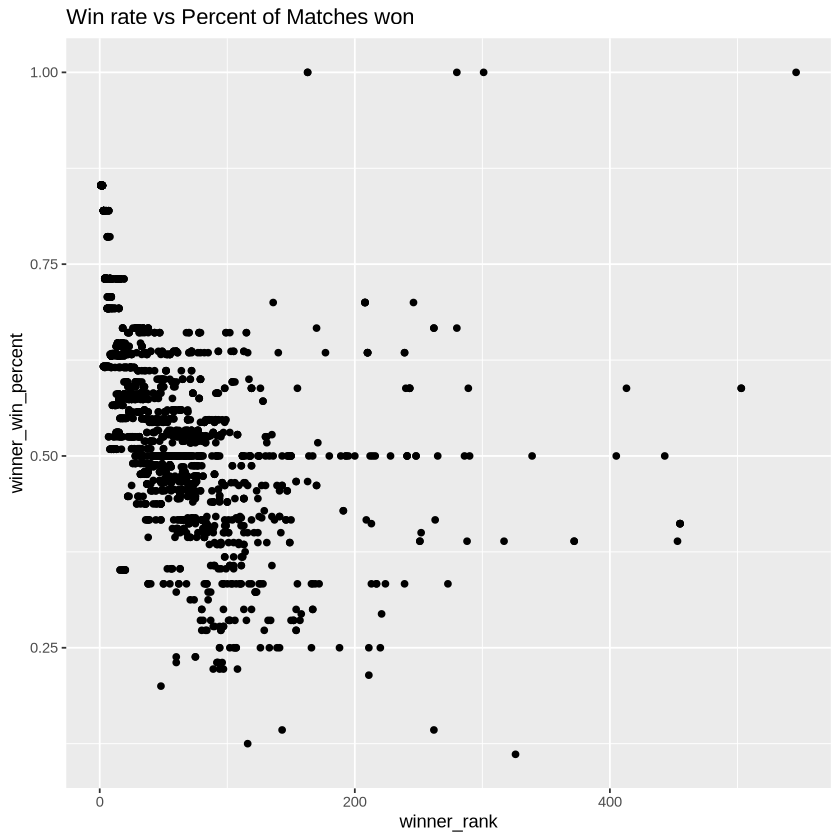

In [210]:
##Summarized data

match_training


## Note: average rank is slightly inaccurate due to not taking into consideration the ranks when players lost their match
## For example, Federer's significant ranking difference between the two tables is mostly likely due to a bad tournament where he lost many games and his ranking dropped as a result.

## Sample plot of winner_rank vs win_percentage
winner_plot <- ggplot(match_training, aes(x=winner_rank, y=winner_win_percent)) +
    geom_point() +
    ggtitle("Win rate vs Percent of Matches won")
winner_plot


## Methods

Firstly, we imported the tennis database into Jupyter. Then, we will transform our data to better suit our data analysis. Currently, the columns describing the two players of a game are labeled “winner” and "loser”, but we will change their labels to “player 1” and “player 2”. To allow for easier classification, we will create a column titled “winner” and have the variables be either “player 1” or “player 2” to display the player that won. The columns we will use to predict the winner will be a player’s average rank, and a new column called win percentage. To create this new column, we will find a player’s total number of wins and divide it by the total number of games they have played. These columns will be important to our project as they are the strongest indicator that a player will win a game. One way we can visualize our results is by plotting the percent accuracy of our results in a bar graph format and comparing it to the accuracy of a predictor only using player rank and the accuracy of another predictor only using win percentage. By doing this, we can ascertain if our predictor is more accurate than other simpler models. 


## Expected outcomes and significance

We expect to find the winner between two professional tennis players with a greater accuracy than other simpler forms of prediction.These findings could help professional coaches and fans discover players with higher potential and allow them to decide whom to invest their time in. These findings could also lead to future questions such as “Which player will win a certain tournament?” or on a larger scale, we could ask “Which player will be ranked the highest in the future based on their predicted tournament wins?” Overall, we hope that our predictor will be effective at determining the winner of a tennis match and that it will be useful in future applications. 